# COVID19 - Brazil States

# import Ray

In [24]:
from environs import Env
env = Env()
env.str("CUDA_DEVICE_ORDER",'PCI_BUS_ID')
env.int("CUDA_VISIBLE_DEVICES",1)
env.int("NUMBA_ENABLE_CUDASIM",1)
env.bool("OMPI_MCA_opal_cuda_support",True)

import os
import ray
MB=1024*1024
GB=MB*1024
ray.init(object_store_memory=1*GB,memory=1*GB,\
         driver_object_store_memory=500*MB,num_gpus=5,num_cpus=5, 
         ignore_reinit_error=True) # , include_webui=False, ignore_reinit_error=True)

@ray.remote(num_gpus=1)
def use_gpu():
    print("ray.get_gpu_ids(): {}".format(ray.get_gpu_ids()[0]))
    print("CUDA_VISIBLE_DEVICES: {}".format(os.environ["CUDA_VISIBLE_DEVICES"]))

use_gpu.remote()

2020-07-23 22:44:53,165	INFO resource_spec.py:212 -- Starting Ray with 0.98 GiB memory available for workers and up to 1.0 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-07-23 22:44:53,497	INFO services.py:1170 -- View the Ray dashboard at localhost:8266


ObjectID(a000cd7e4e2270b4ffffffff010000c801000000)

# Import Modules

In [25]:
import urllib.request
import pandas as pd
import numpy as np
from datetime import datetime,timedelta

# Download data

In [76]:
import get_data
LoadData=True

if LoadData:
    get_data.get_data()

Baixando arquivos brasil.io...


In [77]:
df = pd.read_csv("data/dados_total_estados.csv")
df.drop('index', axis=1, inplace=True)
df['date'] = pd.to_datetime(df['date'],format='%Y-%m-%d') 
df = df[df.date<=datetime.strptime("2020-07-24", '%Y-%m-%d')]
display(df)

,date,state,city,place_type,confirmed,deaths,order_for_place,is_last,popEst,city_ibge_code,confirmed_per_100k_inhabitants,death_rate
0,2020-07-23,AC,TOTAL,state,18157,474,129,True,881935.0,12.0,2058.76850,0.0261
1,2020-07-22,AC,TOTAL,state,17979,470,128,False,881935.0,12.0,2038.58561,0.0261
2,2020-07-21,AC,TOTAL,state,17700,469,127,False,881935.0,12.0,2006.95063,0.0265
3,2020-07-20,AC,TOTAL,state,17462,465,126,False,881935.0,12.0,1979.96451,0.0266
4,2020-07-19,AC,TOTAL,state,17295,460,125,False,881935.0,12.0,1961.02887,0.0266
...,...,...,...,...,...,...,...,...,...,...,...,...
3512,2020-02-29,SP,TOTAL,state,2,0,5,False,45919049.0,35.0,0.00436,0.0000
3513,2020-02-28,SP,TOTAL,state,2,0,4,False,45919049.0,35.0,0.00436,0.0000
3514,2020-02-27,SP,TOTAL,state,1,0,3,False,45919049.0,35.0,0.00218,0.0000
3515,2020-02-26,SP,TOTAL,state,1,0,2,False,45919049.0,35.0,0.00218,0.0000


# Model

# SEAIR-D Model Equations

$$\begin{array}{l}\frac{d s}{d t}=-[\beta i(t) + \beta_2 a(t)-\mu] \cdot s(t)\\ 
\frac{d e}{d t}=[\beta i(t) + \beta_2 a(t)] \cdot s(t) -(\sigma+\mu) \cdot e(t)\\ 
\frac{d a}{d t}=\sigma e(t) \cdot (1-p)-(\gamma_2+\mu) \cdot a(t) \\
\frac{d i}{d t}=\sigma e(t) \cdot p - (\gamma + \sigma_2 + \sigma_3 + \mu) \cdot i(t)\\ 
\frac{d r}{d t}=(b + \sigma_2) \cdot i(t) + d \cdot a(t) - \mu \cdot r(t)\\
\frac{d k}{d t}=(a + \sigma_3) \cdot i(t) + c \cdot a(t) + \mu \cdot k(t)
\end{array}$$

$$\gamma = a + b$$

$$\gamma_2 = c + d$$

$$p=0.2$$

The last equation does not need to be solve because:

$$s + e + i + a + r + k = N$$ 

$N$ is the total population of the region, state or country. If you derivate and by considering population constant during the period of simulation, you get the equation of $k$ without depending of the $N$.

$$\frac{d k}{d t}=-(\frac{d e}{d t}+\frac{d a}{d t}+\frac{d i}{d t}+\frac{d r}{d t})$$

The sum of all rates are equal to zero! The importance of this equation is that it conservates the rates.

## Parameters

$\beta$: Effective contact rate [1/min]
    
$\gamma$: from infected Recovery(+Mortality) rate $\gamma=(a+b)$ [1/min]

$\gamma_2$: from assymptomatic Recovery(+Mortality) rate $\gamma=(a+b)$ [1/min]

$a$: mortality of healed from infected  [1/min]

$b$: recovery rate from infected [1/min]

$c$: mortality of healed from assymptomatic [1/min]

$d$: recovery rate from assymptomatic [1/min]

$\sigma$: is the rate at which individuals move from the exposed to the infectious classes. Its reciprocal ($1/\sigma$) is the average latent (exposed) period.

$\sigma_2$: is the rate at which individuals move from the infectious to the healed classes. Its reciprocal ($1/\sigma_2$) is the average latent (exposed) period

$\sigma_3$: is the rate at which individuals move from the infectious to the dead classes. Its reciprocal ($1/\sigma_3$) is the average latent (exposed) period
    
$p$: is the fraction of the exposed which become symptomatic infectious sub-population.

$(1-p)$: is the fraction of the exposed which becomes asymptomatic infectious sub-population.

# Initial parameters

In [28]:
paramOpt=4
changeCSV=False
adjustParam=True
paramSave=False
selectStates=False

## Select Parameters File, Version and Model

In [29]:
if paramOpt==0:
    paramFile="data/param.csv"
    version = "1"
    model = "ManualIC"

if paramOpt==1:
    paramFile="data/param_optimized_DE_Scipy.csv"    
    version = "1002"
    model = "DE_ScipyIC"
    
if paramOpt==2:
    paramFile="data/param_optimized_DE_SciPy_HistMin.csv"
    version = "1002"
    model = "DE_ScipyIC"

if paramOpt==3:
    paramFile="data/param_optimized_Yabox.csv"    
    version = "103"
    model = "YaboxIC"
    
if paramOpt==4:
    paramFile="data/param_optimized_Yabox_HistMin.csv"
    version = "105"
    model = "YaboxIC"

if paramOpt==5:
    paramFile="data/param_optimized_Brute_Force.csv"
    version = "12"
    model = "BruteForceIC"

if paramOpt==6:
    paramFile="data/param_optimized_Brute_Force_HistMin.csv"
    version = "12"
    model = "BruteForceIC"

## Final Adjust in Parameters

In [30]:
dfparam = pd.read_csv(paramFile)
dfparam = dfparam.dropna()

if selectStates:
    states=['SP','MG','AM','PE','ES','RJ']
else:
    states=dfparam.state

if changeCSV:
    dfparam.loc[dfparam.state=='PI','d0'] = 0
    dfparam.loc[dfparam.state=='RR','d0'] = 0
    dfparam.loc[dfparam.state=='AP','d0'] = 0
    dfparam.loc[dfparam.state=='SP','WCASES'] = 0.65

if paramSave:
    dfparam.to_csv(paramFile)    
    
if adjustParam:
    sCorrect=[0.85,1.25,1.0,1.25,1.5,0.95,1.25,1.15,1.11,0.85,0.9]
    #103 [1.25,1.3,1.3,1.3,1.3,1.3,1.3,1.3,1.0,1.0,1.1]
    dfparam.s0=dfparam.s0.multiply(sCorrect[:len(states)], axis=0)

dfparam

,state,start-date,prediction-range,s0,e0,a0,i0,r0,d0,START,RATIO,WCASES,WREC
0,SP,2020-03-15,200,11425444.15,0,0,1419,300,14,0,0.15,0.5758,0.0228
1,ES,2020-04-08,200,640370.00,0,0,52,250,88,1,0.15,0.7422,0.0432
2,MG,2020-03-30,200,1795035.00,0,0,412,250,4,2,0.15,0.3731,0.0303
3,RJ,2020-03-12,200,1243865.00,0,0,820,250,1,35,0.15,0.6334,0.0339
4,CE,2020-03-20,200,1471506.00,0,0,1152,250,16,8,0.15,0.5564,0.0714
5,PE,2020-03-19,200,1139370.15,0,0,1265,250,98,116,0.15,0.7431,0.0459
6,AM,2020-03-24,200,1473115.00,0,0,922,250,53,24,0.15,0.4114,0.0773
7,PA,2020-03-24,200,1302421.00,0,0,1234,250,116,66,0.15,0.7340,0.0497
8,PI,2020-03-24,200,1068113.04,0,0,1549,250,30,31,0.15,0.4410,0.0339
9,RR,2020-03-19,200,943445.60,0,0,1029,250,6,2,0.15,0.5061,0.0229


# Define States Array and Import Solver

In [31]:
# Load solver
%reload_ext autoreload
%autoreload 2
import LearnerYabox_v2b as Learner #Yabox

## Activate Scrolling

In [32]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines){
    return true;}

<IPython.core.display.Javascript object>

## Select the Running Type

In [33]:
allStates=True
cleanRecovered=False
version="8"

display(states)

0     SP
1     ES
2     MG
3     RJ
4     CE
5     PE
6     AM
7     PA
8     PI
9     RR
10    AP
Name: state, dtype: object

## Main Loop

In [34]:
results=[]
if allStates:
    for state in states:        
        query = dfparam.query('state == "{}"'.format(state)).reset_index()
        parameters = np.array(query.iloc[:, 2:])[0]
        f=Learner.Learner.remote(state, *parameters, cleanRecovered, version)
        result = f.train.remote() 
        results.append(result)
else:
    state= "RJ"
    query = dfparam.query('state == "{}"'.format(state)).reset_index()
    parameters = np.array(query.iloc[:, 2:])[0]
    parameters
    cleanRecovered = False
    f=Learner.Learner.remote(state, *parameters, cleanRecovered, version)
    result = f.train.remote() 
    results.append(result)

# #execute all the queue with max_runner_cap at a time    
results = ray.get(results)

2020-07-23 22:45:11,215	WARNING worker.py:1090 -- WARNING: 15 PYTHON workers have been started. This could be a result of using a large number of actors, or it could be a consequence of using nested tasks (see https://github.com/ray-project/ray/issues/3644) for some a discussion of workarounds.


  0%|          | 10/6125000 [00:06<958:51:43,  1.77it/s]


KeyboardInterrupt: 

In [35]:
ray.shutdown()

# Plots

In [78]:
%matplotlib inline 
import matplotlib.pyplot as plt
import pandas as pd
#%load_ext autoreload
%reload_ext autoreload
%autoreload 2
import covid_plots

In [79]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines){
    return false;}

<IPython.core.display.Javascript object>

In [80]:
#select states for plotting log plot
states4Plot=['MG',
               'ES',
               'SP',
               'CE',
               'RJ']

#Choose here your options
#opt=0 all plots
#opt=1 corona log plot
#opt=2 logistic model prediction
#opt=3 bar plot with growth rate
#opt=4 log plot + bar plot
#opt=5 SEAIR-D Model
opt = 0

#number of cases to start plotting model in log graph - real data = 100
startCase=100

In [81]:
#plots one district or all districts
plotStates=True

#select states for plotting
#you need to run (solve) it before plotting
if plotStates:
    states=dfparam.state
    allStates=True

#main state for plotting log graph or SEAIRD plot
state="SP"

#if it is not SEAIRD plot, so plot one state only
if not opt==5:
    allStates=False

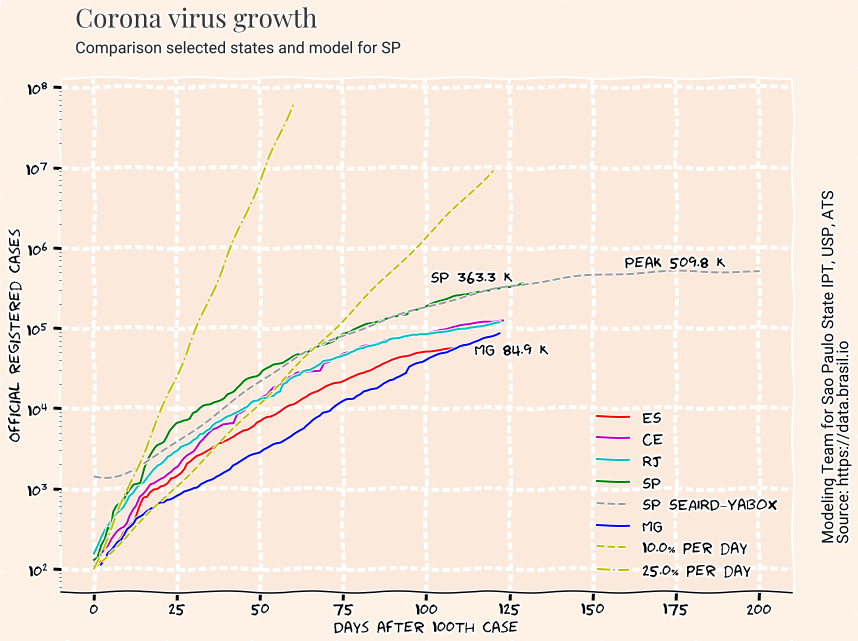

Infection speed= 21.063724463430397
Day with the maximum infections occurred= 108
Total number of recorded infected people at the infection’s end= 609937


/home/ats4i/anaconda3/envs/geo_env/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


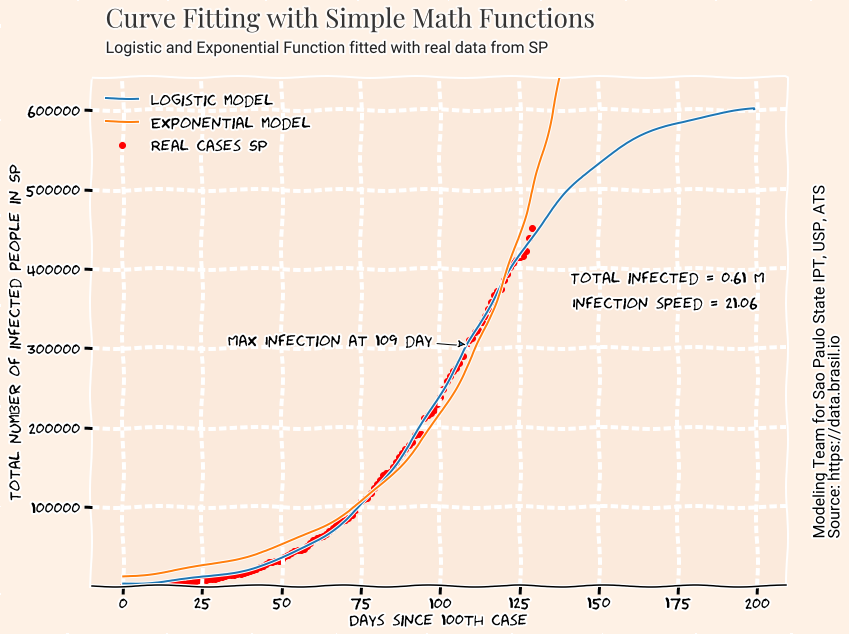

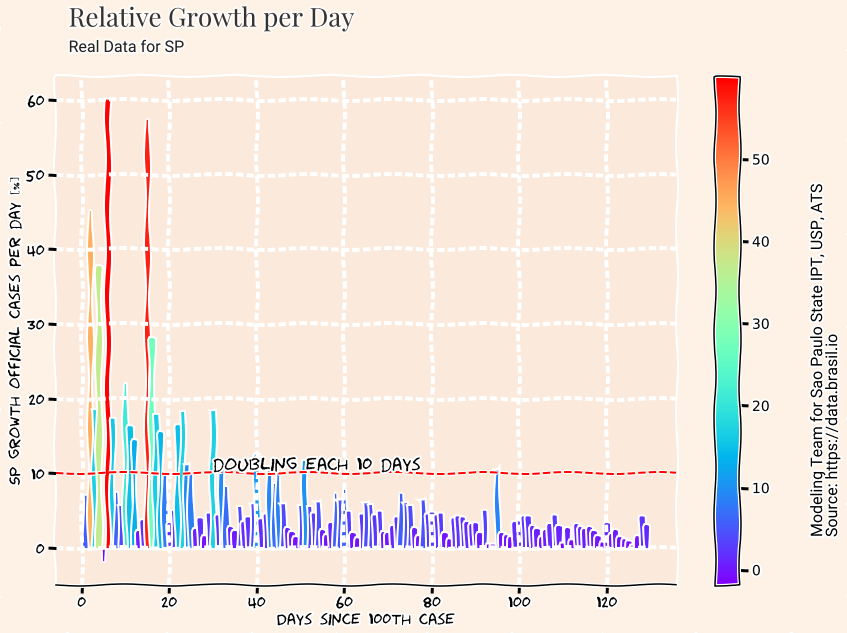

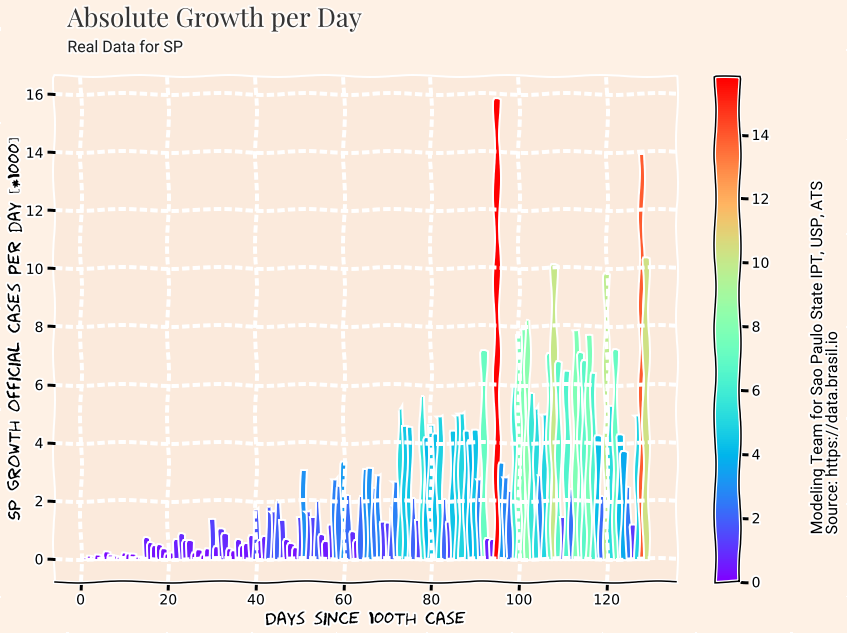

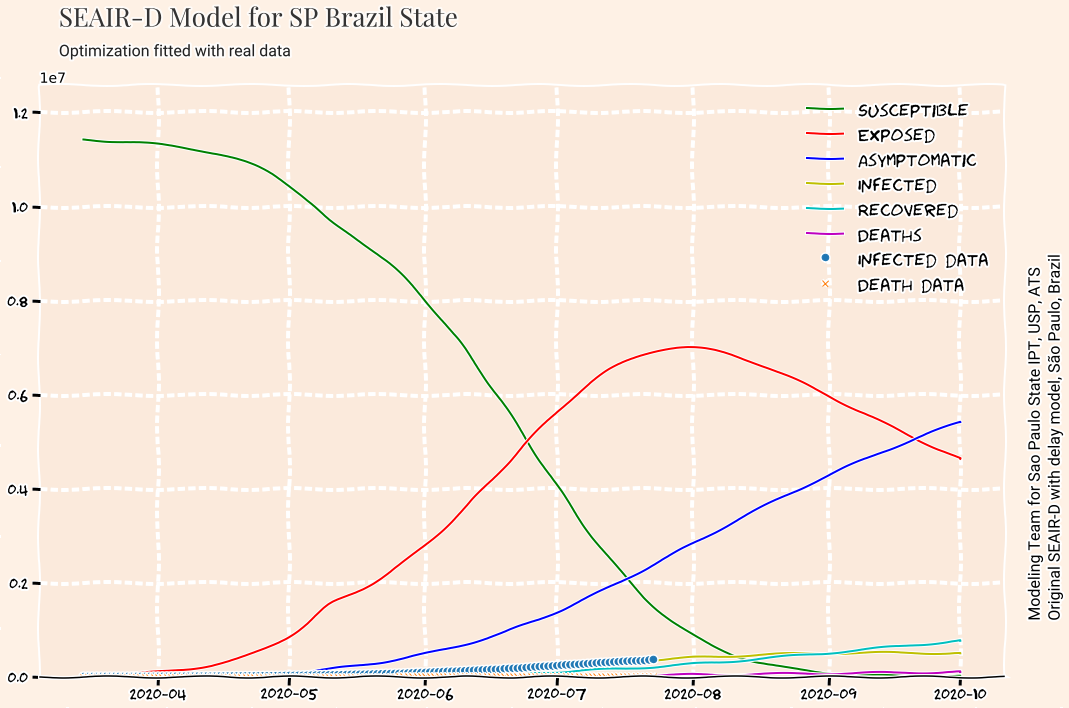

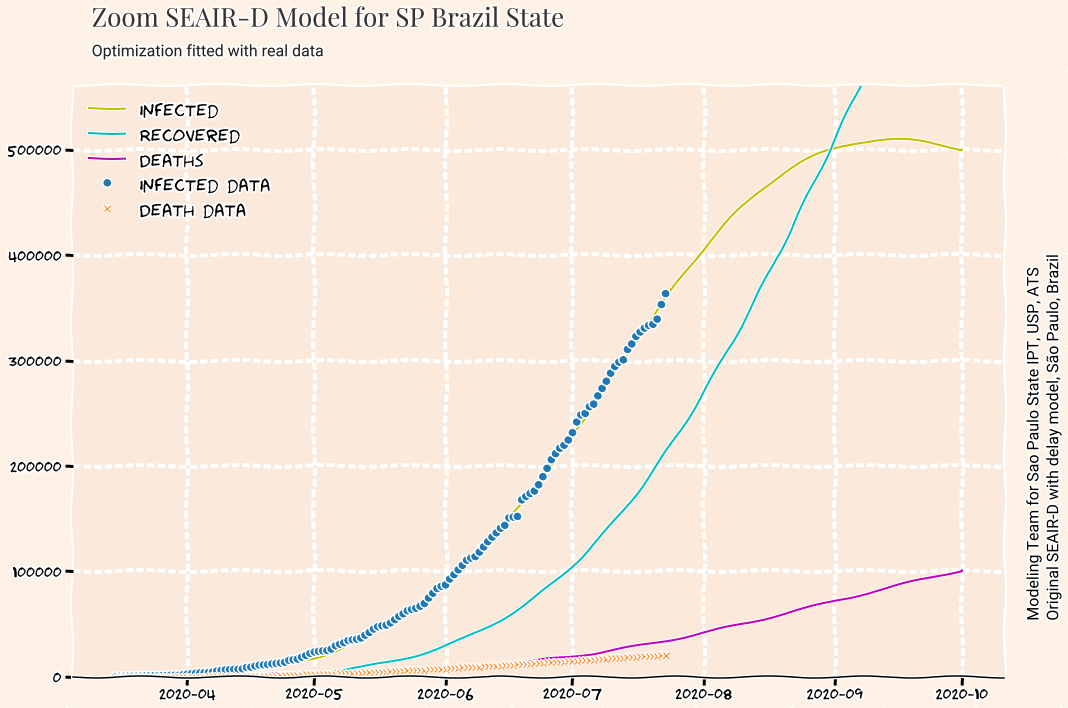

In [82]:
if allStates:
    for state in states:
        query = dfparam.query('state == "{}"'.format(state)).reset_index()
        ratio = query['RATIO'][0]
        startCase = query['START'][0]
        startdate = query['start-date'][0]
        predict_range = query['prediction-range'][0]
        
        #calcula data máxima dos gráficos
        #100 dias é usado como máximo dos cálculos da derivada das mortes
        lastDate=df.date.max()
        maxDate= lastDate + timedelta(days = 100) #"2020-08-31"
        maxDateStr = maxDate.strftime("%Y-%m-%d")

        covid_plots.covid_plots(state, states4Plot, startdate, predict_range, \
                        startCase, opt, version, show=True, ratio=ratio, maxDate=maxDateStr, model=model)
else: 
    query = dfparam.query('state == "{}"'.format(state)).reset_index()
    ratio = query['RATIO'][0]
    startdate = query['start-date'][0]
    predict_range = query['prediction-range'][0]
    startCase = query['START'][0]
    
    #calcula data máxima dos gráficos
    #100 dias é usado como máximo dos cálculos da derivada das mortes
    lastDate=df.date.max()
    maxDate= lastDate + timedelta(days = 100) #"2020-08-31"
    maxDateStr = maxDate.strftime("%Y-%m-%d")    
    
    covid_plots.covid_plots(state, states4Plot, startdate, predict_range, \
                       startCase, opt, version, show=True, ratio=ratio, maxDate=maxDateStr, model=model)